In [ ]:
# default_exp ratio_images

In [ ]:
# hide
# from nbdev.showdoc import *

In [ ]:
# hide
%load_ext autoreload
%autoreload 2

# ratio_images

> API details.

In [ ]:
# export
import re

import numpy as np
import pandas as pd
from clonedetective.utils import extend_region_properties_list, generate_random_cmap
from skimage import img_as_float, io, measure

In [ ]:
# export
def create_img_dict_from_folder(
    load_pattern: str, img_regex: str = r"\w\dg\d\d?", label: bool = False, **kwargs
):
    img_collection = io.ImageCollection(load_pattern, **kwargs)

    img_dict = {
        re.search(img_regex, file)[0]: img_collection[i]
        for i, file in enumerate(img_collection.files)
    }

    if label:
        img_dict = {key: measure.label(value) for key, value in img_dict.items()}

    else:
        img_dict = {key: img_as_float(value) for key, value in img_dict.items()}

    return img_dict

In [ ]:
C0_imgs = create_img_dict_from_folder(load_pattern="data/PercevalHR_data/imgs/*C0.tiff")

C1_imgs = create_img_dict_from_folder(load_pattern="data/PercevalHR_data/imgs/*C1.tiff")

lab_imgs = create_img_dict_from_folder(
    load_pattern="data/PercevalHR_data/segs/*.tif", label=True
)

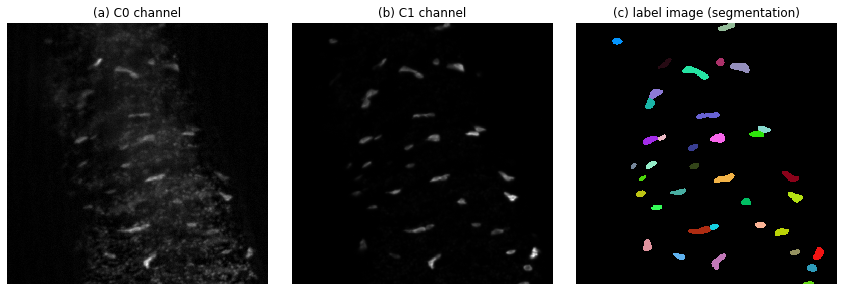

In [ ]:
from clonedetective.utils import plot_new_images

img_name = "a1g01"

plot_new_images(
    [C0_imgs[img_name], C1_imgs[img_name], lab_imgs[img_name]],
    ["C0 channel", "C1 channel", "label image (segmentation)"],
    interpolation="none",
)

In [ ]:
# export
def create_ratio_image(num_img, denom_img, mask_img):
    # convert label image to mask if passed
    mask_img = mask_img > 0
    # add tiny number to prevent possibility of division by zero
    ratio = num_img[mask_img] / (denom_img[mask_img] + 1e-100)
    ratio[ratio >  np.percentile(ratio, 99.9)] = 0
    ratio_image = np.zeros_like(num_img)
    ratio_image[mask_img] = ratio
    return ratio_image

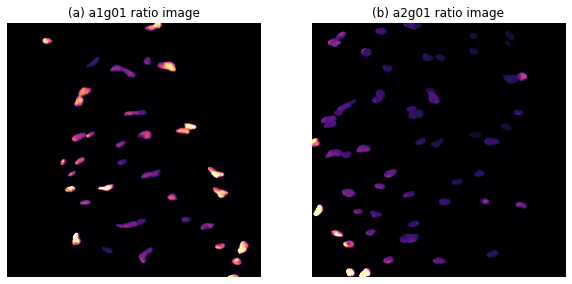

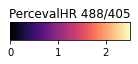

In [ ]:
a1g01_img = create_ratio_image(C1_imgs["a1g01"], C0_imgs["a1g01"], lab_imgs["a1g01"])
a2g01_img = create_ratio_image(C1_imgs["a2g01"], C0_imgs["a2g01"], lab_imgs["a2g01"])

plot_new_images(
    [a1g01_img, a2g01_img],
    ["a1g01 ratio image", "a2g01 ratio image"],
    img_cmap="magma",
    vmax=2.5,
    figure_shape=(1, 2),
    figure_size=(10, 5),
    colorbar=True,
    colorbar_title="PercevalHR 488/405"
)

In [ ]:
# export
def create_dict_of_ratio_images(num_imgs: dict, denom_imgs: dict, lab_imgs: dict):
    ratio_img_dict = {}
    for img_key, lab_img in lab_imgs.items():
        ratio_img_dict[img_key] = create_ratio_image(
            num_imgs[img_key], denom_imgs[img_key], lab_img
        )
    return ratio_img_dict

In [ ]:
ratio_imgs = create_dict_of_ratio_images(C1_imgs, C0_imgs, lab_imgs)

In [ ]:
ratio_imgs.keys()

dict_keys(['a1g01', 'a1g02', 'a1g03', 'a1g04', 'a2g01', 'a2g02', 'a2g03', 'a2g04'])

In [ ]:
# export
def measure_region_props_to_tidy_df(int_imgs: dict, lab_imgs: dict, **reg_prop_kwargs):
    l = list()
    for img_key, img in int_imgs.items():
        df = pd.DataFrame(
            measure.regionprops_table(
                lab_imgs[img_key], intensity_image=img, **reg_prop_kwargs
            )
        )
        df["img_key"] = img_key

        l.append(df)

    return pd.concat(l)

In [ ]:
df = measure_region_props_to_tidy_df(
    C1_imgs, lab_imgs, properties=["label", "mean_intensity"]
)

In [ ]:
df.head()

,label,mean_intensity,img_key
0,1,0.017960,a1g01
1,2,0.012017,a1g01
2,3,0.013259,a1g01
3,4,0.013988,a1g01
4,5,0.025333,a1g01


In [ ]:
# export
def only_intensity_region_properties(properties):
    return [prop for prop in properties if re.search(r"label|intensity", prop)]

In [ ]:
only_intensity_region_properties(["label", "area", "mean_intensity", "centroid"])

['label', 'mean_intensity']

In [ ]:
# export
def ratiometric_measure_region_props_to_tidy_df(
    num_imgs: dict,
    denom_imgs: dict,
    lab_imgs: dict,
    region_properties: list = None,
    **reg_prop_kwargs
):
    num_rprops = extend_region_properties_list(region_properties)
    denom_rprops = only_intensity_region_properties(num_rprops)

    df = pd.merge(
        measure_region_props_to_tidy_df(num_imgs, lab_imgs, properties=num_rprops),
        measure_region_props_to_tidy_df(denom_imgs, lab_imgs, properties=denom_rprops),
        how="left",
        on=("img_key", "label"),
        suffixes=("_num", "_denom"),
    )

    return df.eval("ratio_mean_int = mean_intensity_num/mean_intensity_denom")

In [ ]:
df = ratiometric_measure_region_props_to_tidy_df(C1_imgs, C0_imgs, lab_imgs)
df.head()

,label,area,mean_intensity_num,centroid-0,centroid-1,img_key,mean_intensity_denom,ratio_mean_int
0,1,342,0.017960,7.400585,295.084795,a1g01,0.010094,1.779309
1,2,200,0.012017,35.585000,80.495000,a1g01,0.006473,1.856478
2,3,269,0.013259,79.152416,174.858736,a1g01,0.027961,0.474173
3,4,213,0.013988,76.201878,282.995305,a1g01,0.019588,0.714101
4,5,546,0.025333,86.560440,322.816850,a1g01,0.013664,1.854012


In [ ]:
# export
def split_img_key_col_to_sample_id_and_replicates(
    df,
    split_regex: str,
    img_key_colname: str = "img_key",
    sample_id_colname: str = "sample_id",
    replicate_id_colname: str = "rep_id",
):
    temp_df = df[img_key_colname].str.split(split_regex, expand=True).iloc[:, :2]
    temp_df.columns = [sample_id_colname, replicate_id_colname]

    return pd.concat([df, temp_df], axis=1)

In [ ]:
df = split_img_key_col_to_sample_id_and_replicates(
    df, sample_id_colname="genotype", split_regex=r"g"
)
df.head()

,label,area,mean_intensity_num,centroid-0,centroid-1,img_key,mean_intensity_denom,ratio_mean_int,genotype,rep_id
0,1,342,0.017960,7.400585,295.084795,a1g01,0.010094,1.779309,a1,01
1,2,200,0.012017,35.585000,80.495000,a1g01,0.006473,1.856478,a1,01
2,3,269,0.013259,79.152416,174.858736,a1g01,0.027961,0.474173,a1,01
3,4,213,0.013988,76.201878,282.995305,a1g01,0.019588,0.714101,a1,01
4,5,546,0.025333,86.560440,322.816850,a1g01,0.013664,1.854012,a1,01


In [ ]:
# export
def sample_id_to_categories(
    df,
    sample_id_colname: str = "sample_id",
    old_to_new_sample_ids: dict = None,
    categories: list = None,
):
    if old_to_new_sample_ids is not None:
        df[sample_id_colname].replace(old_to_new_sample_ids, inplace=True)

    df[sample_id_colname] = pd.Categorical(df[sample_id_colname], categories=categories)

    return df

In [ ]:
df = sample_id_to_categories(
    df, sample_id_colname="genotype", old_to_new_sample_ids={"a1": "ctrl", "a2": "mut"}
)
df.head()

,label,area,mean_intensity_num,centroid-0,centroid-1,img_key,mean_intensity_denom,ratio_mean_int,genotype,rep_id
0,1,342,0.017960,7.400585,295.084795,a1g01,0.010094,1.779309,ctrl,01
1,2,200,0.012017,35.585000,80.495000,a1g01,0.006473,1.856478,ctrl,01
2,3,269,0.013259,79.152416,174.858736,a1g01,0.027961,0.474173,ctrl,01
3,4,213,0.013988,76.201878,282.995305,a1g01,0.019588,0.714101,ctrl,01
4,5,546,0.025333,86.560440,322.816850,a1g01,0.013664,1.854012,ctrl,01


In [ ]:
df["genotype"].head()

0    ctrl
1    ctrl
2    ctrl
3    ctrl
4    ctrl
Name: genotype, dtype: category
Categories (2, object): ['ctrl', 'mut']